In [4]:
import sys
import random
import os
import zipfile
import matplotlib
import datetime
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import xgboost as xgb
from xgboost import plot_importance, plot_tree

from pathlib import Path

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
# 한글 폰트
if 'google.colab' in sys.modules:
    !sudo apt-get -qq -y install fonts-nanum
    import matplotlib.font_manager as fm
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

matplotlib.rc('font', family='NanumBarunGothic')
matplotlib.rcParams['axes.unicode_minus'] = False

matplotlib.rcParams['figure.figsize'] = (16, 8)
matplotlib.rcParams['axes.grid'] = False

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121666 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


## 데이터 불러오기

2014-01-01부터 2023-12-13일까지 기온 그래프

In [42]:
df = pd.read_csv("/content/drive/MyDrive/consumption/OBS_ASOS_DD_20231214213751.csv", encoding='euc-kr',index_col=[2], parse_dates=[2])

In [43]:
df = df.drop("지점", axis=1)
df = df.drop("지점명", axis=1)
df = df.rename(columns={'평균기온(°C)':'평균기온'})
df

,평균기온
일시,
2014-01-01,4.0
2014-01-02,1.5
2014-01-03,2.3
2014-01-04,-0.1
2014-01-05,-0.8
...,...
2023-12-09,13.7
2023-12-10,11.4
2023-12-11,8.9


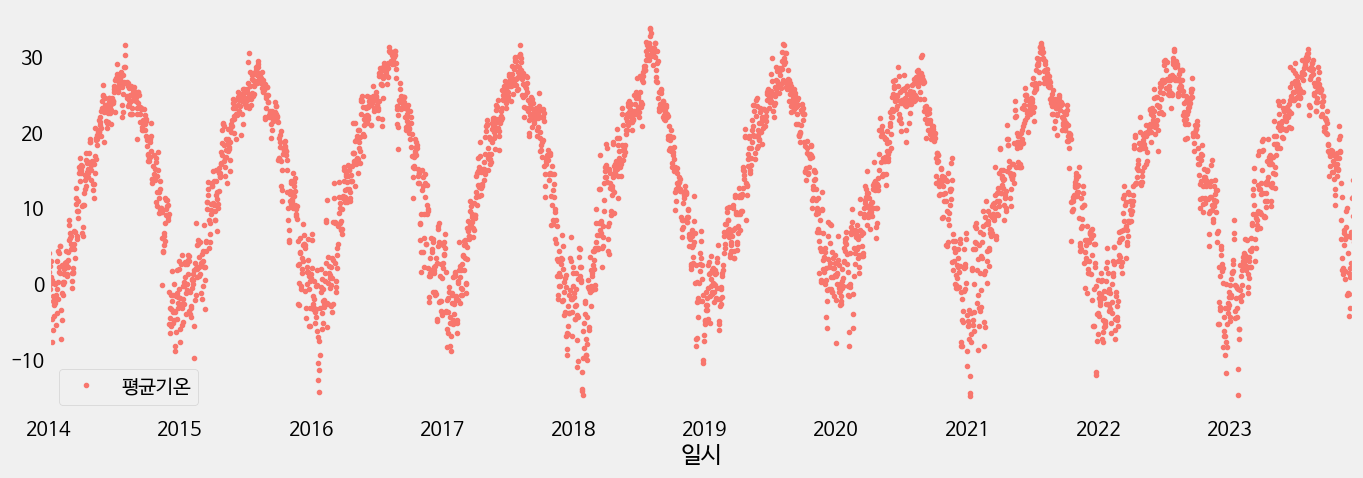

In [44]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = df.plot(style='.', figsize=(15,5), color=color_pal[0],)

### Train, Test 분리

In [45]:
n = len(df)
df_train = df[0:int(n*0.7)]
df_test = df[int(n*0.7):]

In [46]:
df_train

,평균기온
일시,
2014-01-01,4.0
2014-01-02,1.5
2014-01-03,2.3
2014-01-04,-0.1
2014-01-05,-0.8
...,...
2020-12-13,-1.1
2020-12-14,-7.7
2020-12-15,-8.3


In [47]:
df_test

,평균기온
일시,
2020-12-18,-2.1
2020-12-19,-5.1
2020-12-20,-3.7
2020-12-21,-1.0
2020-12-22,2.0
...,...
2023-12-09,13.7
2023-12-10,11.4
2023-12-11,8.9


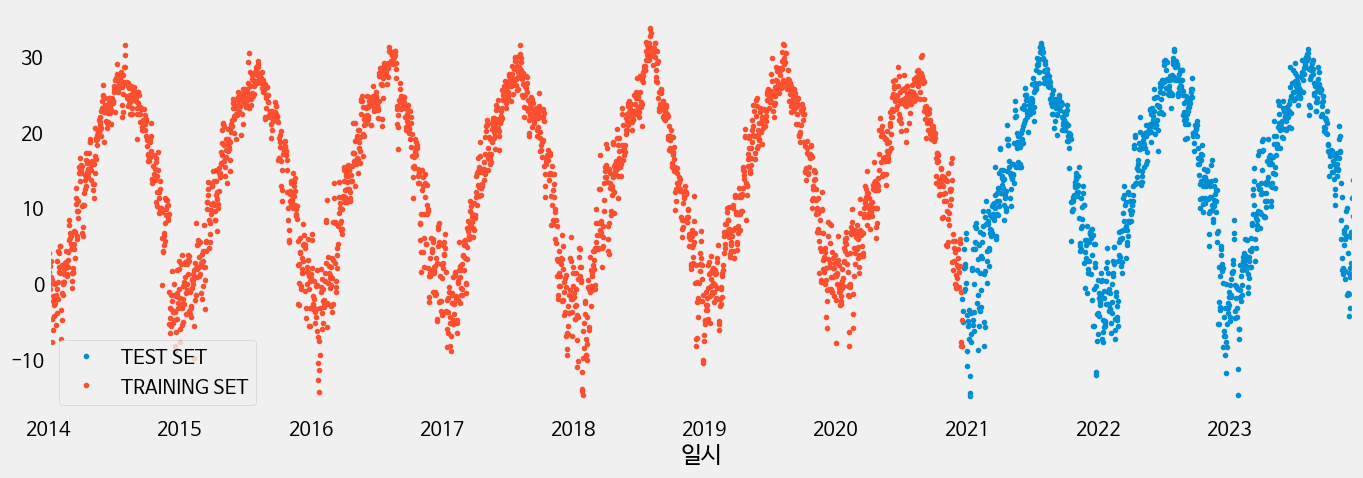

In [48]:
_ = df_test \
    .rename(columns={'평균기온': 'TEST SET'}) \
    .join(df_train.rename(columns={'평균기온': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), style='.')

In [49]:
def create_features(df, label=None):

    df['일시'] = df.index
    df['dayofweek'] = df['일시'].dt.dayofweek
    df['year'] = df['일시'].dt.year
    df['dayofyear'] = df['일시'].dt.dayofyear
    df['dayofmonth'] = df['일시'].dt.day
    df['weekofyear'] = df['일시'].dt.weekofyear

    X = df[['dayofweek','year','dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [50]:
X_train, y_train = create_features(df_train, label='평균기온')
X_test, y_test = create_features(df_test, label='평균기온')

## XGBoost Model 만들기

여러 모델을 돌려 평균치를 가져오는(Bagging) Random Forest와 달리
이상치가 발견될 때 분류작업에서 가중치를 더해주는 (Boosting)방식을 이용한 앙상블 모델

In [51]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

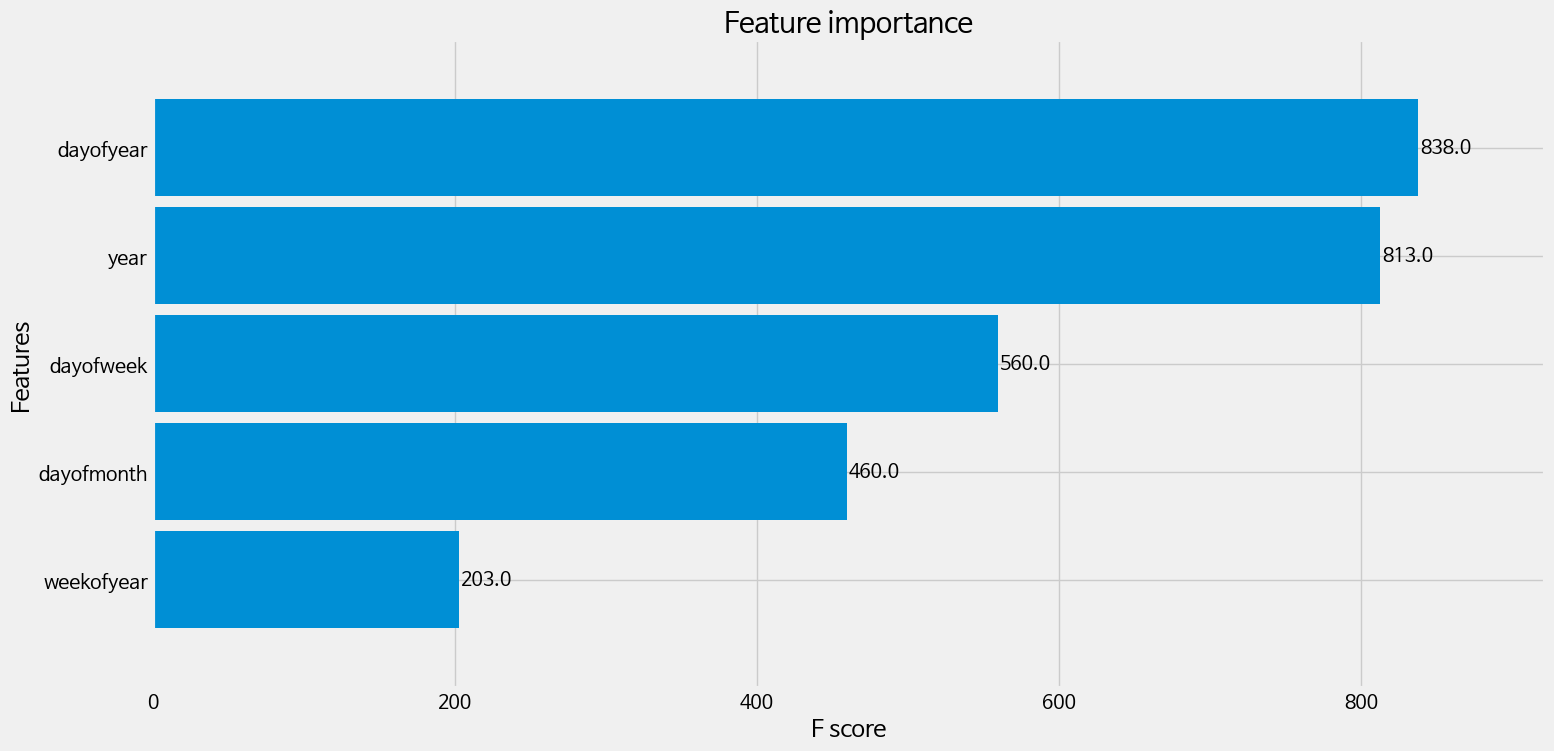

In [52]:
_ = plot_importance(reg, height=0.9)

dayofyear - 연 기준 몇일째 (0-365)일의 데이터가 가장 상관관계가 높고

연도, 주 기준 날짜, 달 기준 날짜, 연 기준 몇 주차인지가 다음으로 상관관계가 높았습니다.

## TestSet에서 예측하기

In [53]:
df_test['예측온도'] = reg.predict(X_test)  # X_test값을 XGBoost Predict값에 넣어준 결과를 df_test['예측온도']에 넣어주기
df_all = pd.concat([df_test, df_train], sort=False)

In [54]:
df_all

,평균기온,일시,dayofweek,year,dayofyear,dayofmonth,weekofyear,예측온도
일시,,,,,,,,
2020-12-18,-2.1,2020-12-18,4,2020,353,18,51,-1.594974
2020-12-19,-5.1,2020-12-19,5,2020,354,19,51,-0.707301
2020-12-20,-3.7,2020-12-20,6,2020,355,20,51,-0.054531
2020-12-21,-1.0,2020-12-21,0,2020,356,21,52,-0.716834
2020-12-22,2.0,2020-12-22,1,2020,357,22,52,-0.716834
...,...,...,...,...,...,...,...,...
2020-12-13,-1.1,2020-12-13,6,2020,348,13,50,NaN
2020-12-14,-7.7,2020-12-14,0,2020,349,14,51,NaN
2020-12-15,-8.3,2020-12-15,1,2020,350,15,51,NaN


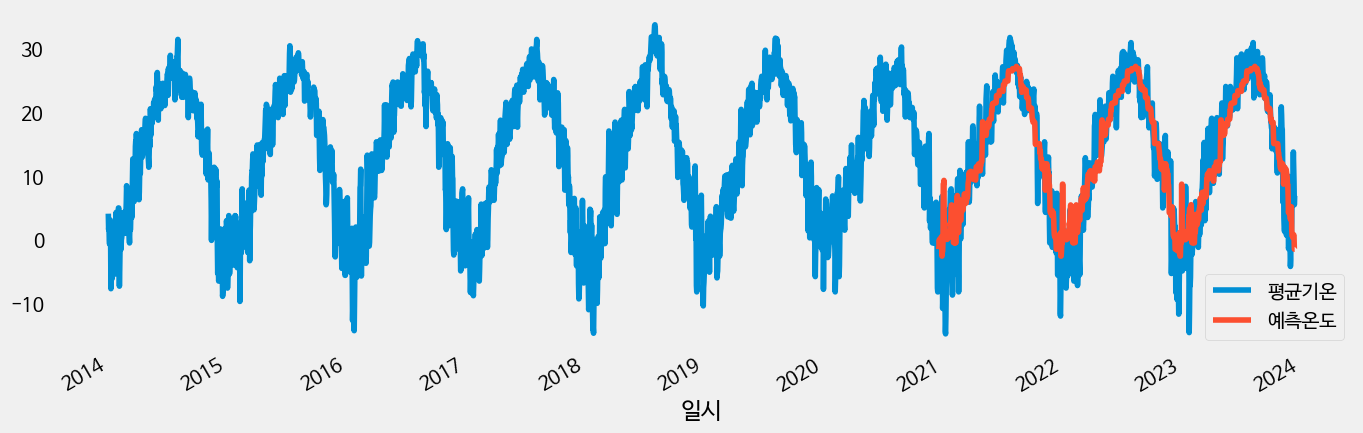

In [55]:
_ = df_all[['평균기온','예측온도']].plot(figsize=(15, 5))

In [56]:
df_all[['평균기온','예측온도']]

,평균기온,예측온도
일시,,
2020-12-18,-2.1,-1.594974
2020-12-19,-5.1,-0.707301
2020-12-20,-3.7,-0.054531
2020-12-21,-1.0,-0.716834
2020-12-22,2.0,-0.716834
...,...,...
2020-12-13,-1.1,NaN
2020-12-14,-7.7,NaN
2020-12-15,-8.3,NaN


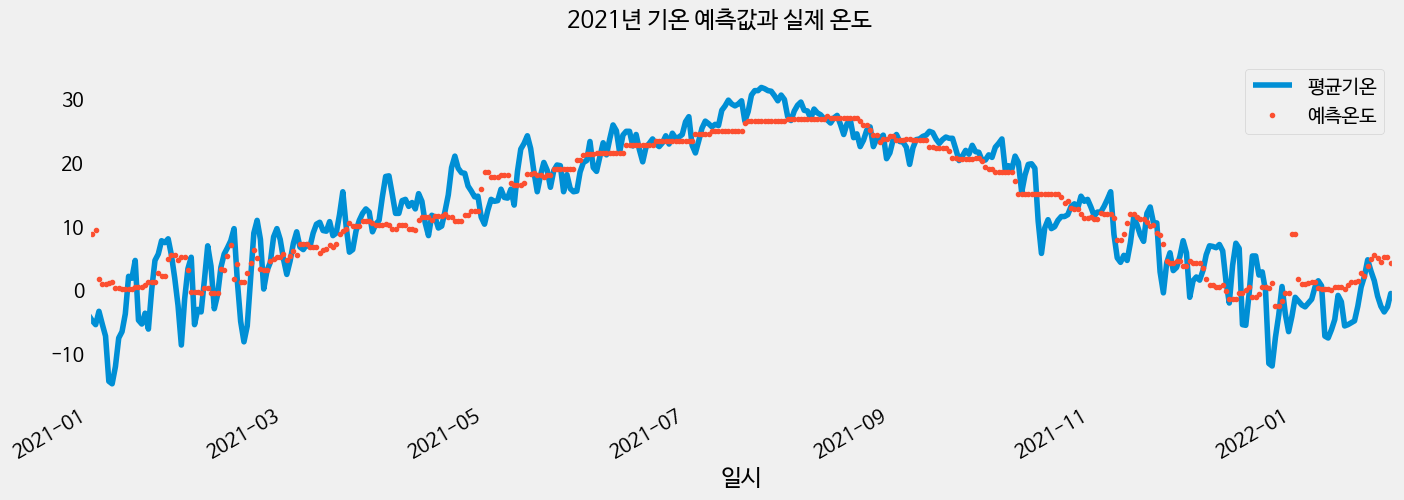

In [57]:

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['평균기온','예측온도']].plot(ax=ax,
                                              style=['-','.'])
# Test셋이 2020년 12월 18일부터이므로
ax.set_xbound(lower='01-01-2021', upper='02-01-2022')
plot = plt.suptitle('2021년 기온 예측값과 실제 온도')

XGBoost의 score메소드를 통해 결정 계수 R^2를 반환
94.82%의 적합성을 보여준다

In [58]:
XGBoost_rmse = reg.score(X_train,y_train)
print(XGBoost_rmse)

0.9482170194922394


## 2024년 기온 예측하기

In [ ]:
start_date = '2024-01-01'
end_date = '2024-12-31'
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
data = {'일시': date_range,
        '평균기온' : None}
pred_df = pd.DataFrame(data)
pred_df = pred_df.set_index(keys='일시')
pred_df

,평균기온
일시,
2024-01-01,None
2024-01-02,None
2024-01-03,None
2024-01-04,None
2024-01-05,None
...,...
2024-12-27,None
2024-12-28,None
2024-12-29,None


In [ ]:
X_pred, y_pred = create_features(pred_df, label='평균기온')
pred_df['예측온도'] = reg.predict(X_pred)

In [ ]:
pred_df

,평균기온,일시,dayofweek,year,dayofyear,dayofmonth,weekofyear,예측온도
일시,,,,,,,,
2024-01-01,None,2024-01-01,0,2024,1,1,1,1.018435
2024-01-02,None,2024-01-02,1,2024,2,2,1,0.189876
2024-01-03,None,2024-01-03,2,2024,3,3,1,0.780016
2024-01-04,None,2024-01-04,3,2024,4,4,1,0.902928
2024-01-05,None,2024-01-05,4,2024,5,5,1,1.147899
...,...,...,...,...,...,...,...,...
2024-12-27,None,2024-12-27,4,2024,362,27,52,-1.383268
2024-12-28,None,2024-12-28,5,2024,363,28,52,-1.277222
2024-12-29,None,2024-12-29,6,2024,364,29,52,0.937626


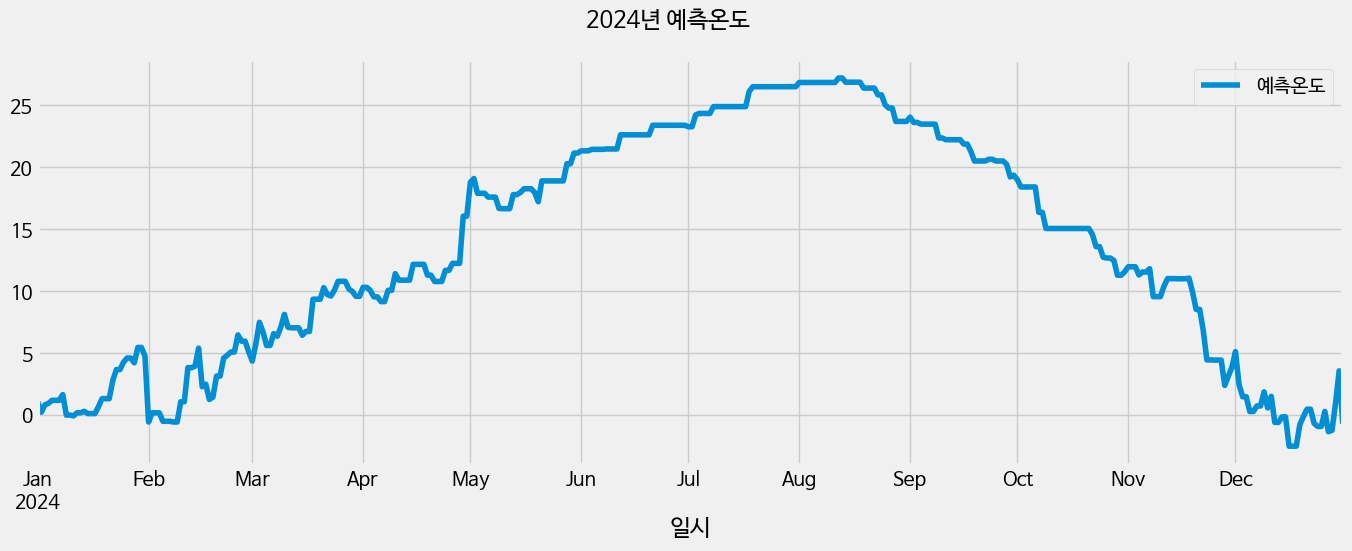

In [ ]:
_ = pred_df[['예측온도']].plot(figsize=(15, 5))
plot = plt.suptitle('2024년 예측온도')

## LSTM 오차 구해보기

시계열 예측

In [5]:
df2 = pd.read_csv("/content/drive/MyDrive/consumption/OBS_ASOS_DD_20231214213751.csv", encoding='euc-kr')

In [6]:
df2 = df2.drop("지점", axis=1)
df2 = df2.drop("지점명", axis=1)
df2 = df2.rename(columns={'평균기온(°C)':'평균기온'})
df2

,일시,평균기온
0,2014-01-01,4.0
1,2014-01-02,1.5
2,2014-01-03,2.3
3,2014-01-04,-0.1
4,2014-01-05,-0.8
...,...,...
3629,2023-12-09,13.7
3630,2023-12-10,11.4
3631,2023-12-11,8.9
3632,2023-12-12,5.4


In [7]:
n = len(df2)
df2_train = df2[0:int(n*0.7)]
df2_test = df2[int(n*0.7):]

In [17]:
df2_train

,일시,평균기온
0,2014-01-01,4.0
1,2014-01-02,1.5
2,2014-01-03,2.3
3,2014-01-04,-0.1
4,2014-01-05,-0.8
...,...,...
2538,2020-12-13,-1.1
2539,2020-12-14,-7.7
2540,2020-12-15,-8.3
2541,2020-12-16,-8.3


In [8]:
train_temp = df2_train['평균기온']
train_temp

0       4.0
1       1.5
2       2.3
3      -0.1
4      -0.8
       ... 
2538   -1.1
2539   -7.7
2540   -8.3
2541   -8.3
2542   -4.9
Name: 평균기온, Length: 2543, dtype: float64

In [27]:
test_temp = df2_test['평균기온']
test_temp

2543    -2.1
2544    -5.1
2545    -3.7
2546    -1.0
2547     2.0
        ... 
3629    13.7
3630    11.4
3631     8.9
3632     5.4
3633     6.8
Name: 평균기온, Length: 1091, dtype: float64

In [9]:
train_temp = list(train_temp)
df2 = {0:train_temp}
df2 = pd.DataFrame(df2)
df2.head()

,0
0,4.0
1,1.5
2,2.3
3,-0.1
4,-0.8


시계열 데이터이므로 LSTM을 위한 Time Series Forecasting 데이터 전처리

In [10]:
def makeSeriesData(df2, n_in = 6):
  for i in range(1, n_in+1):
    df2[i] = df2[i-1].shift(1)
  return df2

df2 = makeSeriesData(df2, 6)
df2.head()

,0,1,2,3,4,5,6
0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1.5,4.0,NaN,NaN,NaN,NaN,NaN
2,2.3,1.5,4.0,NaN,NaN,NaN,NaN
3,-0.1,2.3,1.5,4.0,NaN,NaN,NaN
4,-0.8,-0.1,2.3,1.5,4.0,NaN,NaN


In [11]:
df2 = df2.dropna()
df2 = df2.reset_index(drop=True)
df2.head()

,0,1,2,3,4,5,6
0,3.0,0.8,-0.8,-0.1,2.3,1.5,4.0
1,0.5,3.0,0.8,-0.8,-0.1,2.3,1.5
2,-7.8,0.5,3.0,0.8,-0.8,-0.1,2.3
3,-4.7,-7.8,0.5,3.0,0.8,-0.8,-0.1
4,-1.7,-4.7,-7.8,0.5,3.0,0.8,-0.8


In [12]:
df2 = np.array(df2)
X_train, y_train = df2[:,:-1], df2[:,-1]

In [13]:
print(X_train.shape)
print(y_train.shape)

(2537, 6)
(2537,)


LSTM Model

In [14]:
from keras.layers import Embedding, Dense, LSTM, Dropout, Flatten, TimeDistributed, Conv1D, MaxPooling1D
from keras.models import Model
from keras import Input
from keras.models import Sequential

Model 만들기

In [15]:
model = Sequential()
model.add(LSTM(256, kernel_initializer = 'he_normal', activation = 'relu', input_shape=(6,1)))
model.add(Dense(64, kernel_initializer = 'he_normal', activation='relu'))
model.add(Dense(1))
model.compile(loss = 'mse', optimizer = 'adam')

model.fit(X_train,y_train, epochs = 150, batch_size = 32, verbose = 0)

예측하고 평가하기

In [16]:
def model_predict(model, history,input_Length):
  X_input = np.array(history[-input_Length:]).reshape(1, input_Length,1)
  Y_hat = model.predict(X_input)
  return Y_hat[0]

In [21]:
print(df2_train.shape)

(2543, 2)


In [28]:
test_temp

2543    -2.1
2544    -5.1
2545    -3.7
2546    -1.0
2547     2.0
        ... 
3629    13.7
3630    11.4
3631     8.9
3632     5.4
3633     6.8
Name: 평균기온, Length: 1091, dtype: float64

In [37]:
test_Predict = model_predict(model,train_temp,6)

print('2021년 12월 18일 예측 온도 : %.2f' %test_Predict)
print('2021년 12월 18일 실제 온도 : %.2f' %test_temp.iloc[0])

1/1 [==============================] - 0s 73ms/step
2021년 12월 18일 예측 온도 : 0.81
2021년 12월 18일 실제 온도 : -2.10


history가 데이터에서 맨 뒤에서 input_Length 앞서 결정한 6개의 수치를 가져옵니다. 그리고 이 Vector의 Shape를 변경해서 LSTM 모델에 입력하고 예측 값을 얻습니다.

특정 수치를 예측하고자 하는 회귀 문제이기 때문에 rmse(평균 제곱근 오차)를 이용해서 모델의 Error를 계산해보겠습니다.

In [31]:
def rmse(outputs, labels):
  return np.sqrt(((outputs - labels) ** 2).mean())

In [32]:
def walk_forward_validation(model,train_Data,test_Data,input_Length):
  predict_List = []
  history = train_Data.copy()
  for i in range(len(test_Data)):
    Y_hat = model_predict(model, history, input_Length)
    predict_List.append(Y_hat)
    history.append(test_Data[i])
  predict_Array = np.array(predict_List)
  error = rmse(predict_Array, test_Data)
  return error, predict_List

In [34]:
error, predictions = walk_forward_validation(model, list(train_temp), list(test_temp), 6)

1/1 [==============================] - 0s 19ms/step


In [59]:
print('LSTM Error value : %.3f' %error)

LSTM Error value : 14.879


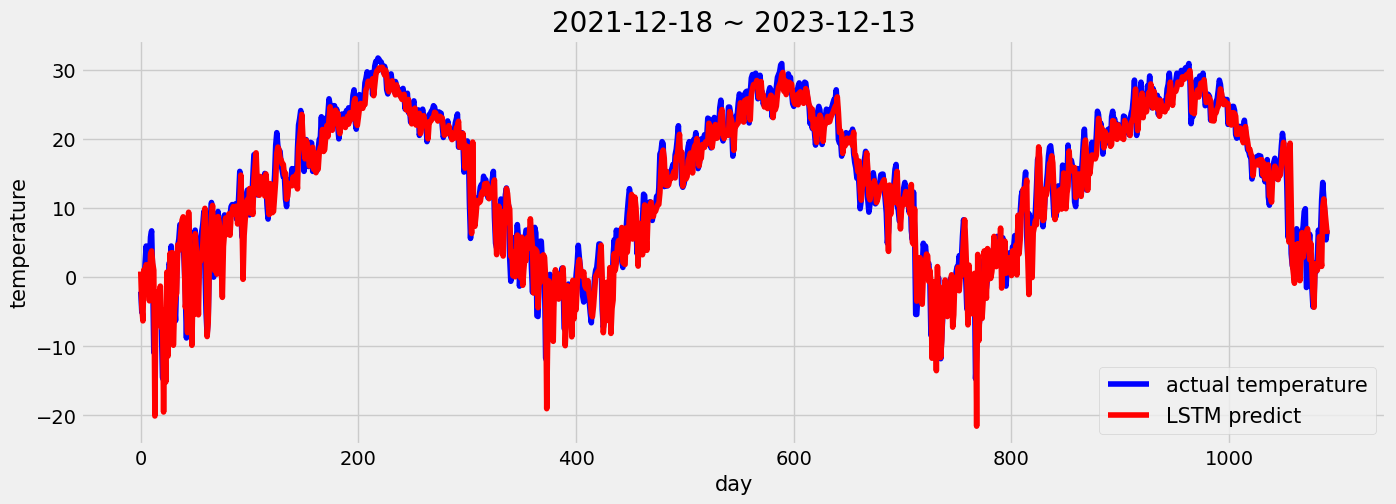

In [39]:
plt.figure(figsize=(15,5))
plt.title('2021-12-18 ~ 2023-12-13', fontsize = 20)
plt.xlabel('day', fontsize=15)
plt.ylabel('temperature', fontsize=15)
idx_List = list(range(len(test_temp)))
plt.plot(idx_List, test_temp, 'b', label='actual temperature')
plt.plot(idx_List, predictions, 'r', label = 'LSTM predict')
plt.legend(loc='best',fontsize=15)